In [6]:
import pandas as pd

df = pd.read_parquet('yelp_academic_dataset_business_cleaned.parquet')

df.to_csv('yelp_academic_dataset_business_cleaned.csv', index=False)

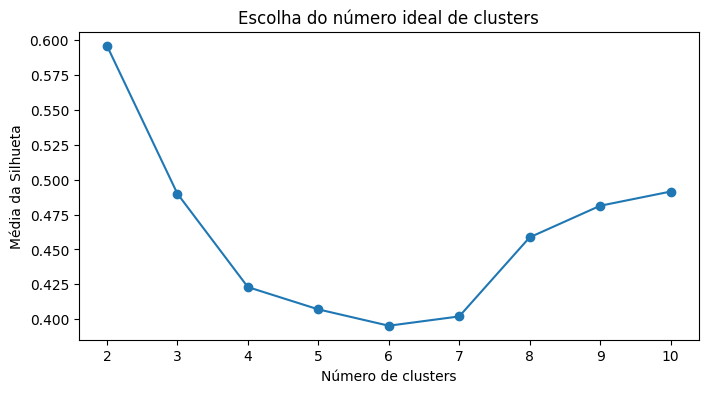

Melhor número de clusters: 2


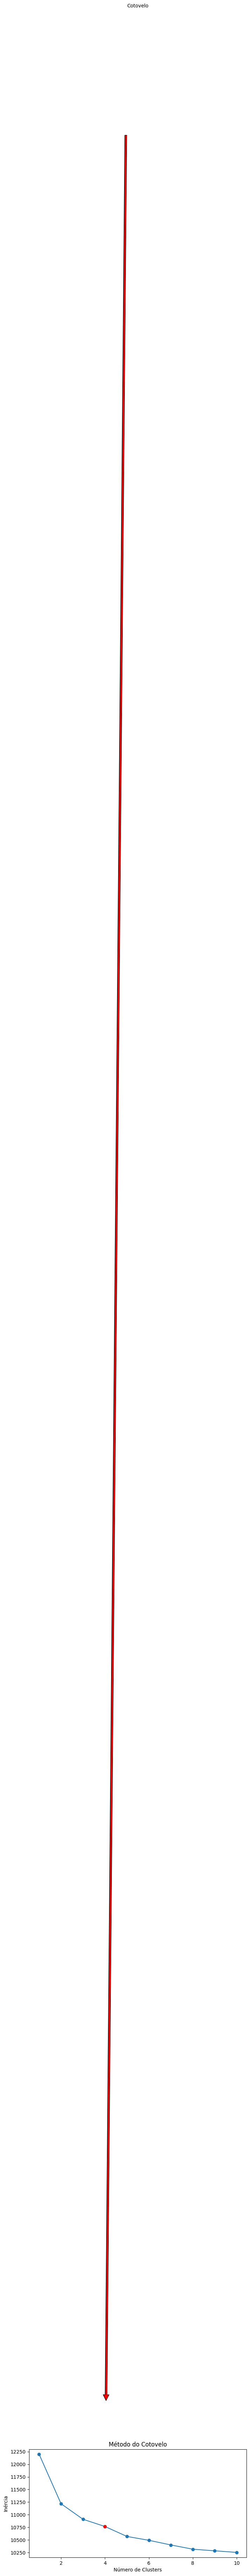

Média da silhueta para 3 clusters: 0.4899552907550028
Média da silhueta para 4 clusters: 0.4229829849915149
Média da silhueta para 5 clusters: 0.40698464444006666
Média da silhueta para 6 clusters: 0.3952532891216948
Média da silhueta para 7 clusters: 0.4019337087068907
Média da silhueta para 8 clusters: 0.4586765571083715


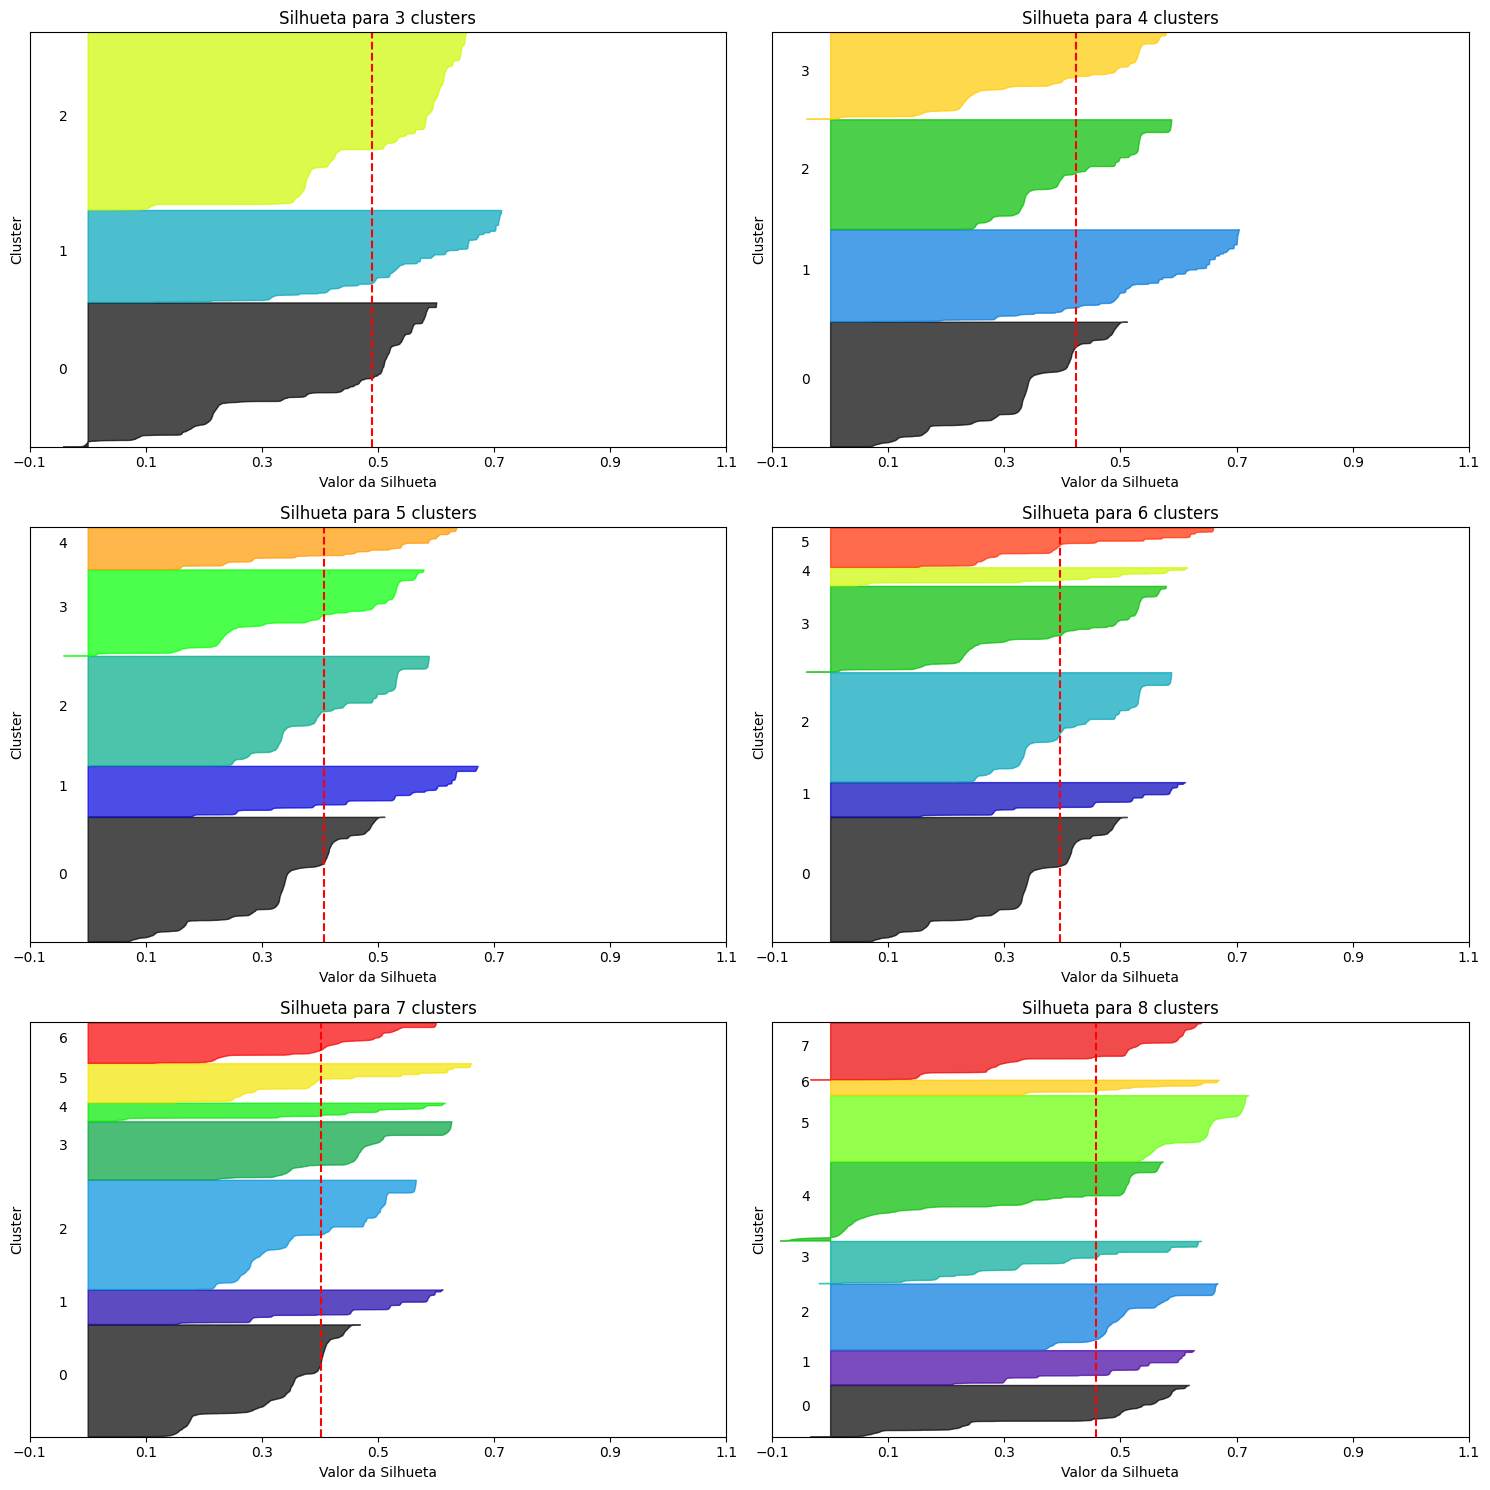

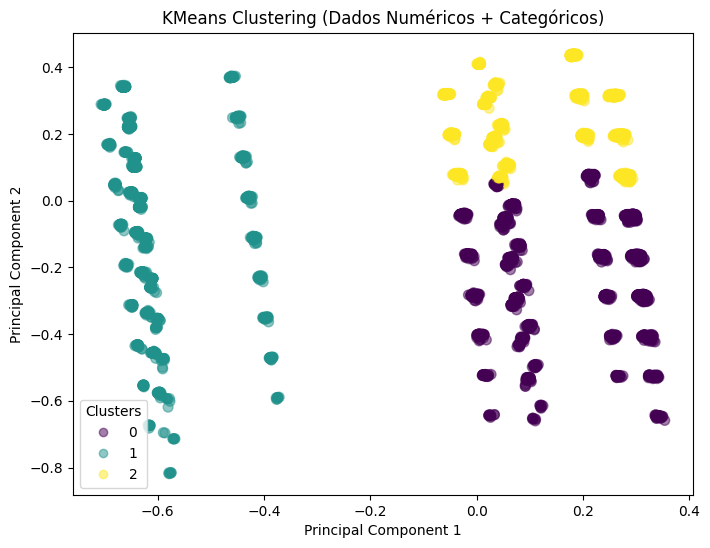

            stars  review_count   latitude   longitude  cluster
cluster                                                        
0        2.802210     35.652098  36.195194  -81.881153      0.0
1        3.684529     42.219283  39.725316 -115.635876      1.0
2        4.389527     53.905958  35.709967  -82.275242      2.0

Dados do Cluster 2:


,stars,review_count,latitude,longitude,categories,cluster
21792,4.0,11,40.012639,-75.218269,"hair stylists, beauty & spas, nail salons, mas...",2
117044,5.0,27,27.944405,-82.503058,"hair stylists, beauty & spas, hair extensions,...",2
103413,5.0,8,36.125898,-86.844593,"active life, fitness & instruction, barre clas...",2
44660,4.0,16,40.079390,-75.211864,"health & medical, ear nose & throat, doctors",2
126469,4.5,8,38.682328,-90.359762,"shopping, restaurant supplies, home & garden, ...",2



Dados do Cluster 0:


,stars,review_count,latitude,longitude,categories,cluster
124085,2.5,5,38.511302,-90.443527,"restaurants, barbers, hair salons, beauty & sp...",0
139956,3.5,10,36.083502,-86.872224,"active life, golf",0
90031,3.5,9,29.925246,-90.070297,"optometrists, convenience stores, food, shoppi...",0
120942,3.5,10,40.196581,-74.811157,"local services, self storage",0
6359,2.0,159,40.006065,-75.286460,"car dealers, auto repair, used car dealers, au...",0



Dados do Cluster 1:


,stars,review_count,latitude,longitude,categories,cluster
101605,4.5,7,53.601015,-113.423833,"dentists, general dentistry, cosmetic dentists...",1
145522,2.5,17,32.222678,-110.877178,"contractors, shopping, home services, kitchen ...",1
86060,5.0,5,32.235862,-110.873570,"martial arts, fitness & instruction, active life",1
109080,4.5,50,43.609850,-116.289633,"pressure washers, gutter services, home cleani...",1
63351,5.0,10,34.397574,-119.517138,"food, food delivery services, farmers market, ...",1


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA  

# Carregar os dados
df = pd.read_csv('yelp_academic_dataset_business_cleaned.csv')

# Reduzir para 10.000 amostras para melhor desempenho
sampled_df = df.sample(n=10000, random_state=2)

# Selecionar colunas relevantes
columns = ['stars', 'review_count', 'latitude', 'longitude', 'categories']
sampled_df = sampled_df[columns]

# Separar variáveis numéricas e categóricas
numeric_features = ['stars', 'review_count', 'latitude', 'longitude']
categorical_features = ['categories']

# Normalizar numéricos e transformar categóricos em One-Hot Encoding
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Aplicar transformação
processed_data = preprocessor.fit_transform(sampled_df)
processed_data_dense = processed_data.toarray()

# Redução de dimensionalidade com PCA (2 componentes)
pca = PCA(n_components=2, random_state=2)
processed_data_pca = pca.fit_transform(processed_data_dense)

# MÉTODO DA SILHUETA PARA ESCOLHER O MELHOR K
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(processed_data_pca)
    score = silhouette_score(processed_data_pca, labels)
    silhouette_scores.append(score)

# 🔹 Plotar o gráfico do coeficiente de silhueta
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Média da Silhueta')
plt.title('Escolha do número ideal de clusters')
plt.show()

#  ESCOLHER O MELHOR K (pode ser o de maior pontuação)
best_k = k_values[np.argmax(silhouette_scores)]
print(f'Melhor número de clusters: {best_k}')

# clusterização - Método do Cotovelo
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=2)
    kmeans.fit(processed_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')

# Destacar o ponto de quebra do cotovelo em vermelho
best_k_elbow = np.argmin(np.diff(inertia, 2)) + 2  # Encontrar o ponto de cotovelo automaticamente
plt.plot(best_k_elbow, inertia[best_k_elbow-1], 'ro')  # Ponto em vermelho
plt.annotate('Cotovelo',
             xy=(best_k_elbow, inertia[best_k_elbow-1]),
             xytext=(best_k_elbow + 1, inertia[best_k_elbow-1] + 50000),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()

# Definir o intervalo de clusters
range_n_clusters = range(3, 9)

# Criar a figura para os subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

# Loop para calcular e plotar a silhueta para cada número de clusters
for idx, n_clusters in enumerate(range_n_clusters):
    ax1 = axes[idx]
    
    # Configurar o subplot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(processed_data_pca) + (n_clusters + 1) * 10])
    
    # Treinar K-Means com o número de clusters atual
    kmeans = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = kmeans.fit_predict(processed_data_pca)
    
    # Calcular a média da silhueta
    silhouette_avg = silhouette_score(processed_data_pca, cluster_labels)
    print(f'Média da silhueta para {n_clusters} clusters: {silhouette_avg}')
    
    # Calcular os valores da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(processed_data_pca, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax1.set_title(f'Silhueta para {n_clusters} clusters')
    ax1.set_xlabel('Valor da Silhueta')
    ax1.set_ylabel('Cluster')
    
    # Desenhar a linha vertical para a média da silhueta
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

# Ajustar o layout
plt.tight_layout()
plt.show()

# clusterização 
kmeans_model = KMeans(n_clusters=3, random_state=2)

# Ajustar o modelo e obter as previsões
kmeans_result = kmeans_model.fit_predict(processed_data)

# Adicionar a coluna 'cluster' ao DataFrame
sampled_df['cluster'] = kmeans_result

# Reduzir a dimensionalidade para 2D com PCA para o gráfico de dispersão
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(processed_data)

# Plotar os clusters
plt.figure(figsize=(8, 6))

scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_result, cmap='viridis', s=50, alpha=0.5)

# Adicionar títulos e rótulos aos eixos
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering (Dados Numéricos + Categóricos)')

# Adicionar legenda
plt.legend(*scatter.legend_elements(), title="Clusters")

# Exibir o gráfico
plt.show()

# Gerar tabela com dados de cada cluster
numeric_columns = sampled_df.select_dtypes(include=[np.number]).columns
cluster_means = sampled_df.groupby('cluster')[numeric_columns].mean()
print(cluster_means)

# Mostrar dados de cada cluster
for cluster in sampled_df['cluster'].unique():
    print(f"\nDados do Cluster {cluster}:")
    display(sampled_df[sampled_df['cluster'] == cluster].head())
